In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations as A
import tensorflow as tf

from PIL import Image
from glob import glob
from tqdm import tqdm

# Ensemble Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dense, Input, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.layers import Flatten, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Feature Extractor 4 models
# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as Incep_preprocess_input

# Xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xcep_preprocess_input

# NasNetMobile
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input as Nas_preprocess_input

# EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as Eff_preprocess_input

# ResNet
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ResNet_preprocess_input

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

print('train_df shape :',train_df.shape)

train_df shape : (9912, 14)


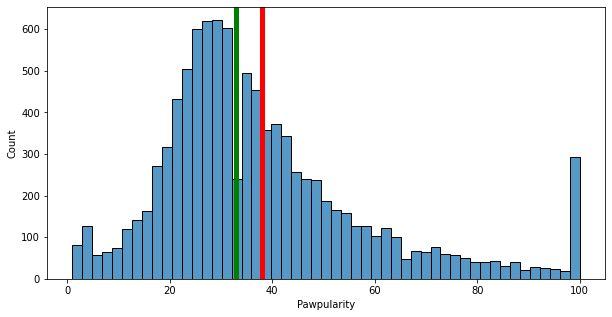

In [3]:
plt.figure(figsize =(10, 5))
sns.histplot(train_df['Pawpularity'])
plt.axvline(train_df['Pawpularity'].mean(), color = 'red', linewidth = 5)
plt.axvline(train_df['Pawpularity'].median(), color = 'green', linewidth = 5)

In [4]:
train_df[['Pawpularity']].describe().T 

,count,mean,std,min,25%,50%,75%,max
Pawpularity,9912.0,38.039044,20.59199,1.0,25.0,33.0,46.0,100.0


In [5]:
# 점수대 별로 나눠보기

def get_category(paw):
    if paw > 0.9 and paw <= 20.8:
        paw = 5
    elif paw > 20.8 and paw <= 40.6:
        paw = 4
    elif paw > 40.6  and paw <= 60.4:
        paw = 3
    elif paw > 60.4  and paw <= 80.2:
        paw = 2
    elif paw > 80.2:
        paw = 1
    
    return paw

train_df['Paw_band'] = pd.cut(train_df['Pawpularity'], 5)
train_df[['Paw_band', 'Pawpularity']].groupby(['Paw_band'], as_index = False).mean().sort_values(by = 'Paw_band', ascending = True)

train_df['Paw_band'] = train_df['Pawpularity'].apply(lambda x : get_category(x))

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Paw_band
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,2
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,3
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,4
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,5
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,2


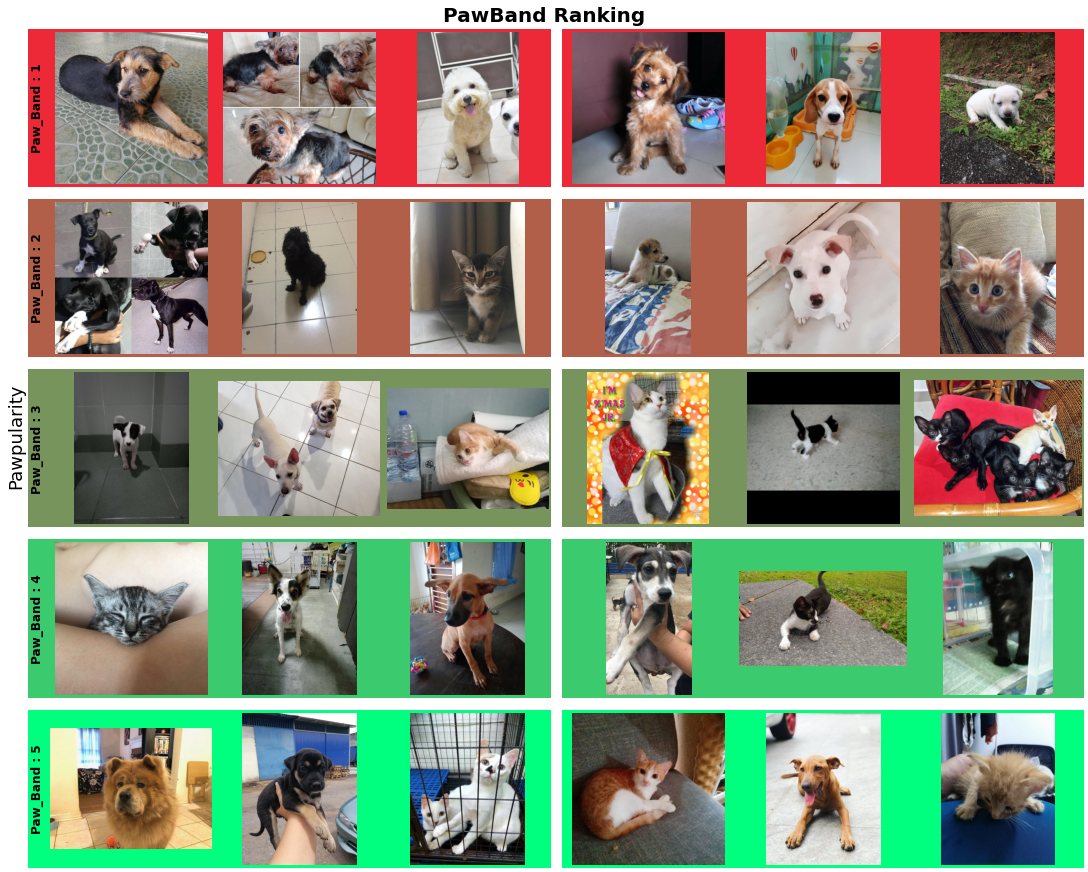

In [6]:
def feature_example(feature):
    colors = ["#ED2938", "#B25F4A", "#77945C", "#3BCA6D", "#00FF7F"]
    figs = plt.figure(constrained_layout = True, figsize = (15, 12))
    subfigs = figs.subfigures(5, 2, hspace=0.07)
    for idx, fig in enumerate(subfigs, 1):
        axes = fig[0].subplots(1, 3)
        fig[0].supylabel('Paw_Band : {}'.format(idx), fontweight = 'bold')
        fig[0].set_facecolor(colors[idx - 1])
        
        feature_sub = feature[feature['Paw_band'] == idx].sample(3, random_state = 0)        
        for image_id, ax in zip(feature_sub['Id'], axes):
            ax.imshow(Image.open('./train/' + image_id + '.jpg'))
            ax.axis('off')
        
        axes = fig[1].subplots(1, 3)
        fig[1].set_facecolor(colors[idx - 1])
        
        feature_sub = feature[feature['Paw_band'] == idx].sample(3, random_state = 1)
        for image_id, ax in zip(feature_sub['Id'], axes):
            ax.imshow(Image.open('./train/' + image_id + '.jpg'))
            ax.axis('off')
        
        
    figs.suptitle('PawBand Ranking' , fontweight = 'bold', fontsize = 20)
    figs.supylabel('Pawpularity', fontsize = 18)
    
    plt.show()

feature_example(train_df)

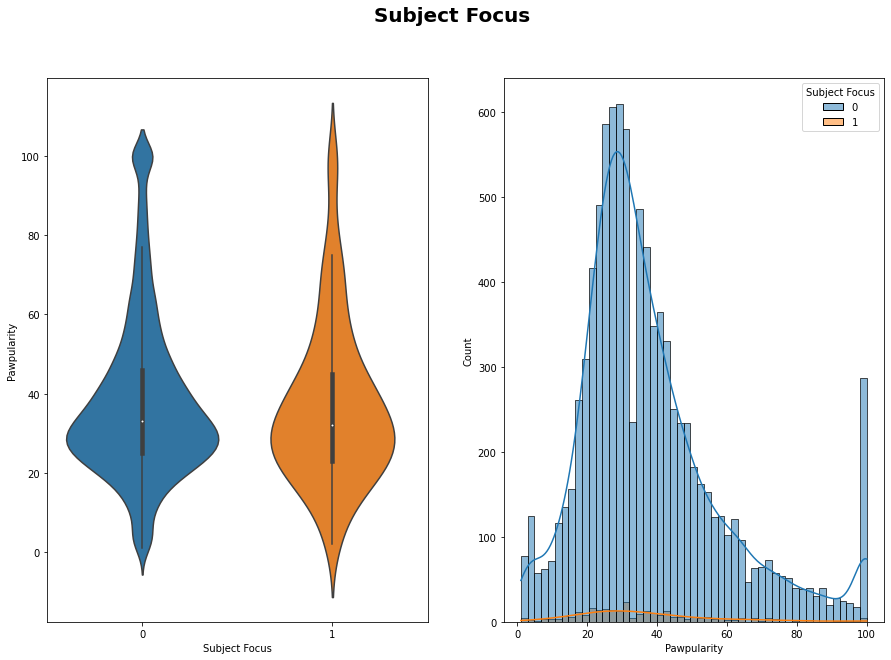

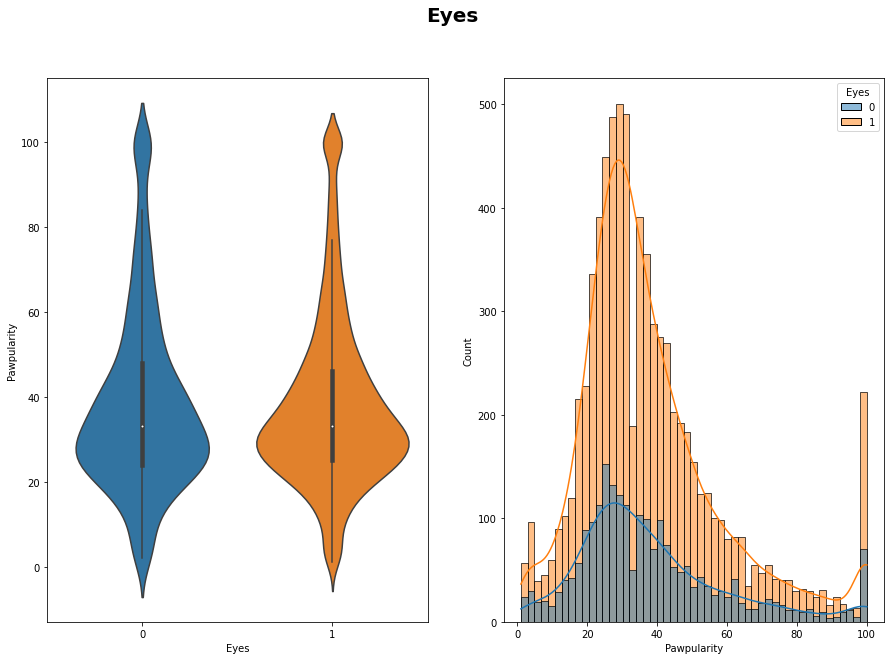

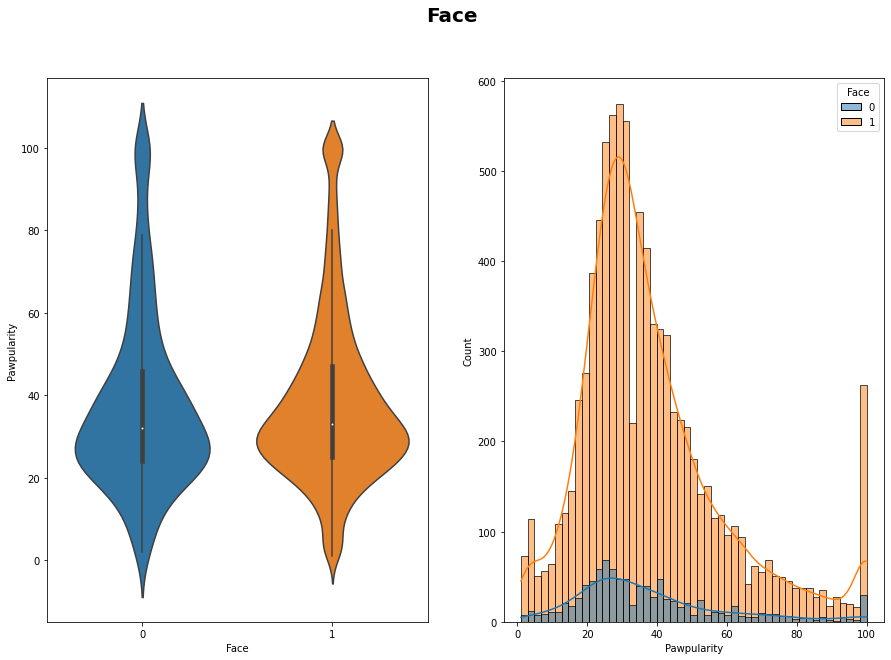

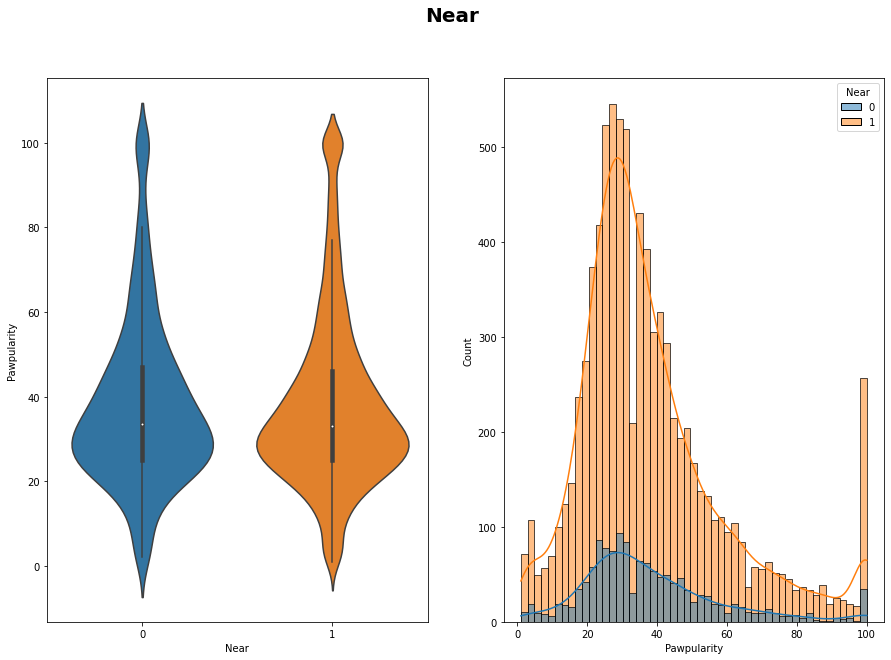

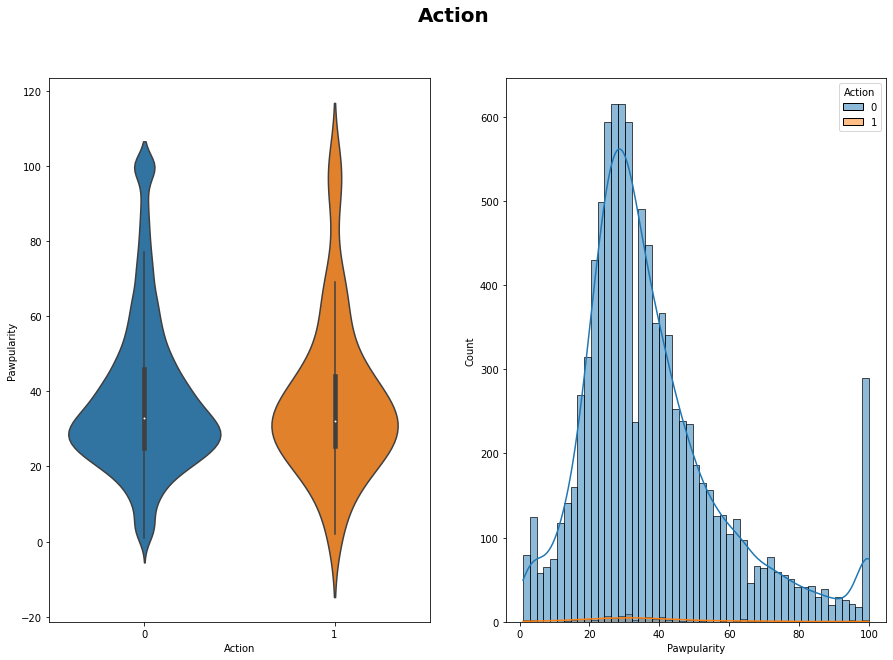

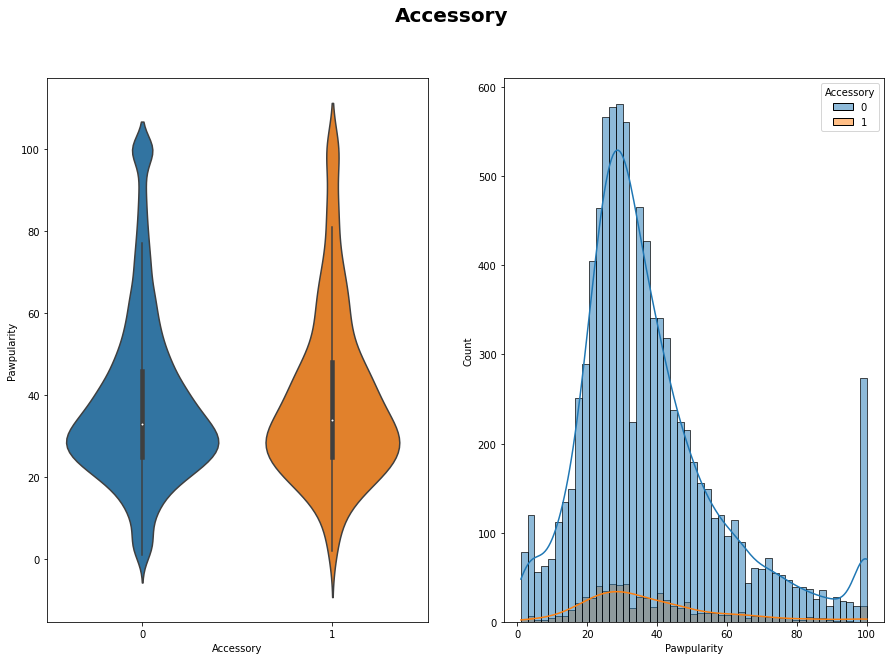

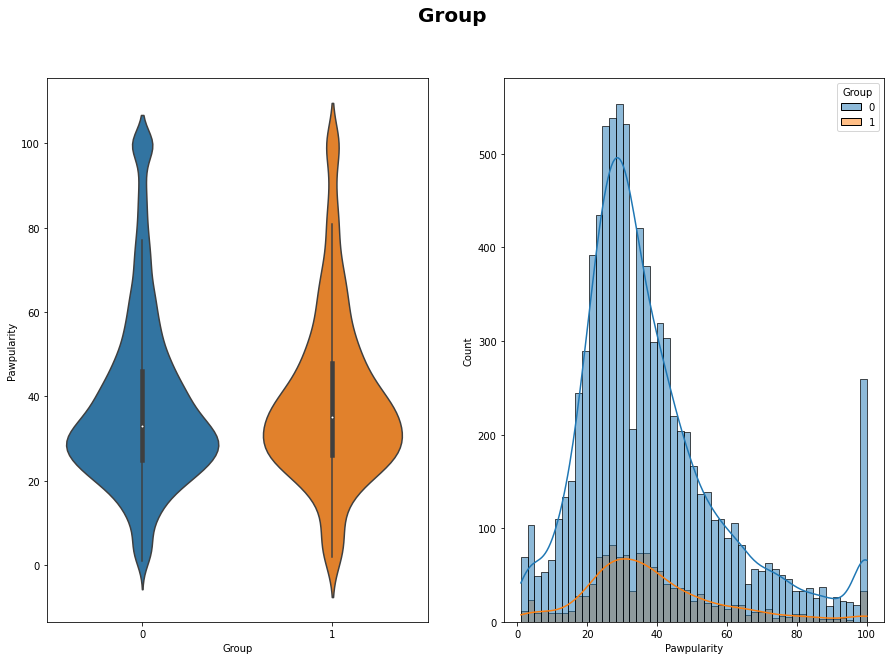

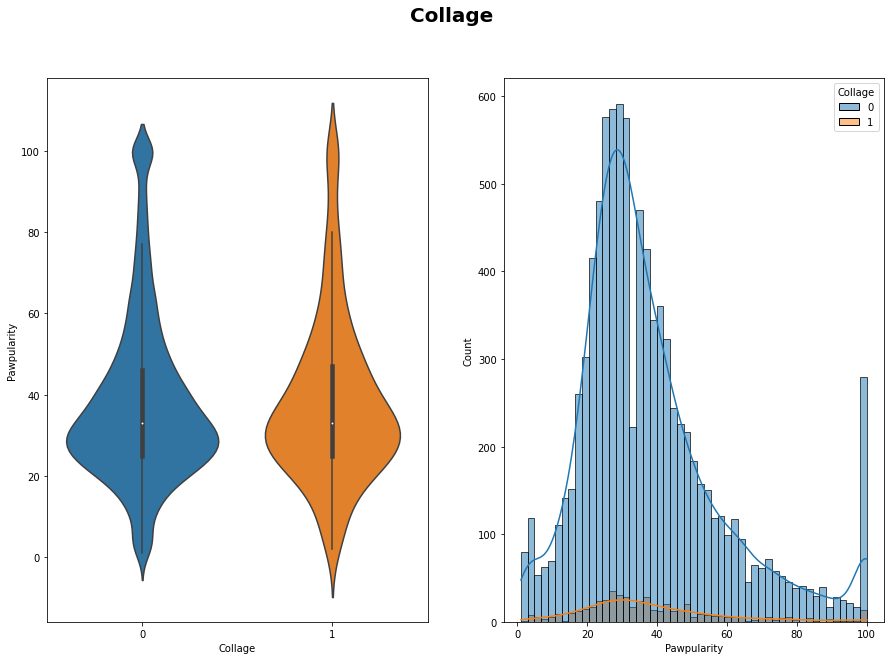

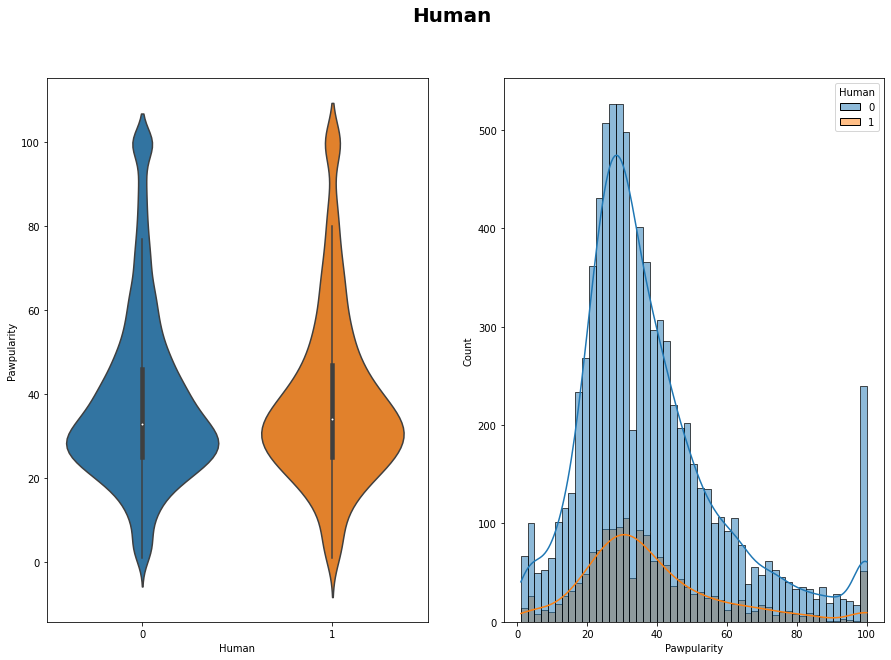

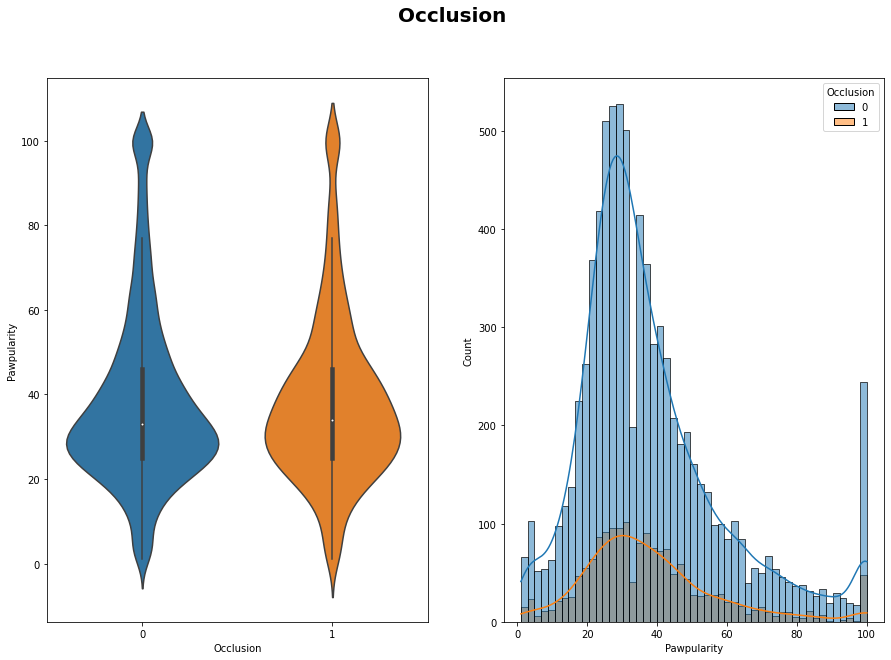

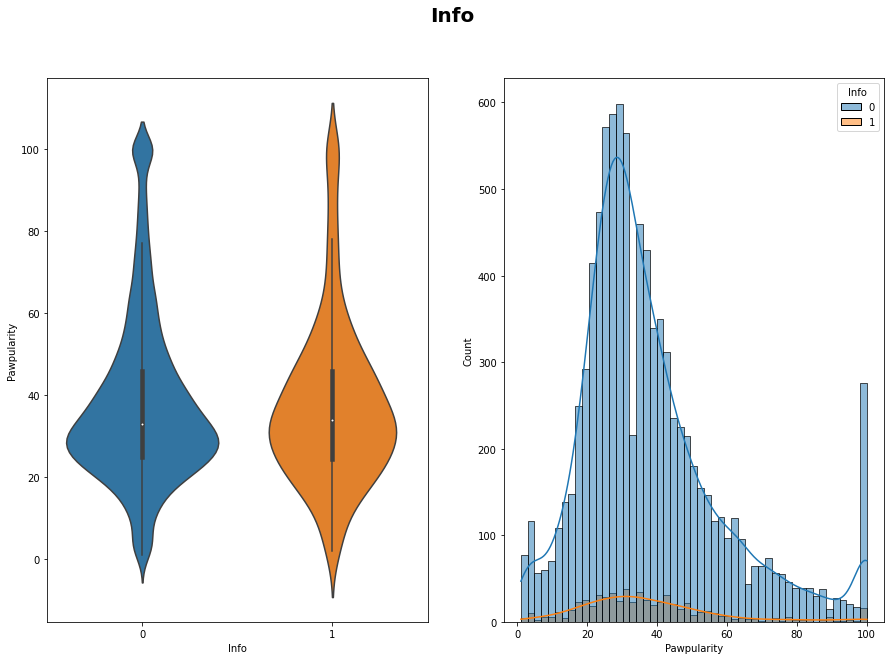

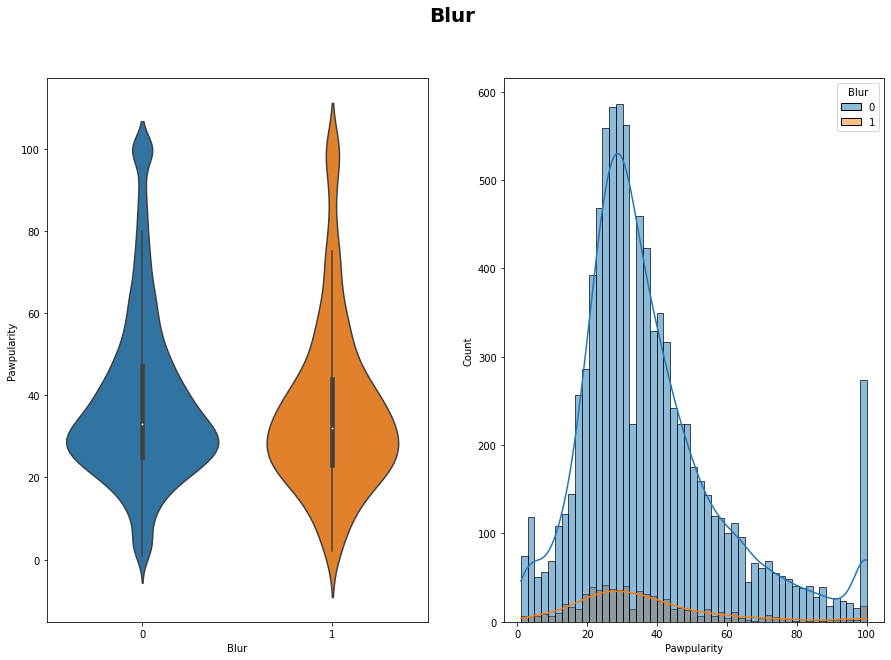

In [7]:
cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

for col in cols:
    fig, ax = plt.subplots(1,2, figsize = (15, 10))
    sns.violinplot(data = train_df, y = 'Pawpularity', x = col, ax = ax[0])
    sns.histplot(data = train_df, x = 'Pawpularity', hue = col, kde = True, ax = ax[1])
    plt.suptitle(str(col), fontsize = 20, fontweight = 'bold')

In [8]:
train_df['img_path'] =  './train/' + train_df['Id'] + '.jpg'
test_df['img_path'] =  './test/' + test_df['Id'] + '.jpg'

Image_Size = (224, 224, 3)

def Image_resize(frame, Image_Size = (224, 224, 3)):
    images_path = frame['img_path'].tolist()
    datasize = len(images_path)
    
    image_array = np.zeros([datasize, Image_Size[0], Image_Size[1], Image_Size[2]], dtype = np.float32)
    for i in tqdm(range(datasize)):
        img_pixels = load_img(images_path[i], target_size = Image_Size)
        image_array[i] = img_pixels
    
    print('Image_array shape', image_array.shape)
    
    return image_array

train_image = Image_resize(train_df)
train_label = train_df['Pawpularity']

100%|█████████████████████████████████████████████████████████████████████████████| 9912/9912 [00:54<00:00, 180.97it/s]

Image_array shape (9912, 224, 224, 3)


# Feature Extractor

In [9]:
def get_features(model_name, data_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    
    base_model = model_name(weights = 'imagenet', include_top = False, input_shape = input_size)(preprocessor)
    
    x = GlobalAveragePooling2D()(base_model)
    
    feature_extractor = Model(inputs = input_layer, outputs = x)
    feature_maps = feature_extractor.predict(data, batch_size = 64, verbose = 1)
    print('Feature_maps : ', feature_maps.shape)
    
    return feature_maps

In [10]:
# Inceptionv3
Image_Size = (224, 224, 3)
inception_preprocessor = Incep_preprocess_input
inception_features = get_features(InceptionV3, inception_preprocessor, Image_Size, train_image)

# Xception
Xception_preprocessor = Xcep_preprocess_input
xception_features = get_features(Xception, Xception_preprocessor, Image_Size, train_image)

# NASNetMobile
Nasnet_preprocessor = Nas_preprocess_input
nasnet_features = get_features(NASNetMobile, Nasnet_preprocessor, Image_Size, train_image)

# EfficientNet
Eff_preprocessor = Eff_preprocess_input
efficient_features = get_features(EfficientNetB0, Eff_preprocessor, Image_Size, train_image)

# InceptionResNetV2
ResNet_preprocessor = ResNet_preprocess_input
ResNet_features = get_features(InceptionResNetV2, ResNet_preprocessor, Image_Size, train_image)

final_features = np.concatenate([inception_features, xception_features,
                                 nasnet_features, efficient_features,
                                 ResNet_features], axis = -1)

print('final_features :', final_features.shape)



ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [ ]:
ely_cb = EarlyStopping(monitor = 'val_rmse', patience = 10, restore_best_weight = True)

DNN_model = Sequential([
    InputLayer(final_features[1:]),
    Dropout(0.7),
    Dense(1)
])

DNN_model.compile(loss = 'mse', optimizer = 'adam', metrics = [tr.keras.metrics.RootMeanSquaredError(name = 'rmse')])

history = DNN_model.fit(final_features, train_label, batch_size = 128, epochs = 60, validation_split = 0.1, callbacks = [ely_cb])

In [ ]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right");

In [ ]:
test_image = Image_resize(test_df)

inception_features = get_features(InceptionV3, inception_preprocessor, Image_Size, test_image)
xception_features = get_features(Xception, Xception_preprocessor, Image_Size, test_image)
nasnet_features = get_features(NASNetMobile, Nasnet_preprocessor, Image_Size, test_image)
efficient_features = get_features(EfficientNetB0, Eff_preprocessor, Image_Size, test_image)
ResNet_features = get_features(InceptionResNetV2, ResNet_preprocessor, Image_Size, test_image)

final_features = np.concatenate([inception_features, xception_features,
                                 nasnet_features, efficient_features,
                                 ResNet_features], axis = -1)


pred = DNN_model.predict(final_features, batch_size = 128)
submision = pd.DataFrame({
    'Id' : test_df['Id']
    'Pawpularity' : pred
})
submision.to_csv('submision.csv', index = False)